# Ciencia de Datos
## 2º Cuatrimestre de 2017

## Módulo 3 - Machine Learning

## Integrantes:

- Fernández, Esteban - 691/12 - esteban.pmf@gmail.com
- Beccar García, Augusto - 267/13 - abg101@gmail.com
- Fadel, Uriel - 104/14 - urielfadel@gmail.com


## Introducción

En este trabajo utilizaremos los datos analizados en el anterior trabajo práctico para, mediante el uso de técnicas de Machine Learning, predecir si un paciente presenta un estado de consciencia normal o de mínima consciencia.

 El objetivo de Machine Learning es clasificar un conjunto de nuevas obserbaciones a partir de otro conjunto de muestras con distintos features o rasgos que representan un valor cuantitativo ciertas características de lo que se quiere clasificar. En nuestro casa la clasificación es binaria, un paciente puede ser etiquetado como S (de consciencia normal) o P (de mínima consciencia) y el conjunto de datos ya se encuentra etiquetado por lo que el aprendizaje es supervisado. Esto significa que el clasificador puede establecer alguna relación entre dichas etiquetas y los distintos feauteres en el conjunto de entrenamiento para aproximar a la función que determina el comportamiento observado. Como los conjuntos sobre los que se testea (es decir sobre los que se quiere predecir si pertenece a una clase y otra) también estan etiquetados (pues son un subconjuto de la información capturada por el electroencefalograma para 20 pacientes en el anterior trabajo), podemos establecar algunas métricas con el fin de evaluar la performance del modelo (como por ejemplo, el porcentaje de aciertos sobre el total clasificado). 
 
Lo primero que haremos es extraer los feautres presentados por los pacientes que van a estar determinados por algun valor cuantitativo (por ejemplo el promedio) de las potencias para distintas bandas de frecuencia de algún electrodo considerado relevante en la captura de la reacción del individuo, así como también de la entropía inter e intraelectrodo.
Luego se evaluará el nivel de relevancia de cada feauture, entendido como la capacidad de esa variable a la hora de clasificar y tras esto utilizaremos dos clasificadores, logistic regression y support vector machine para predecir la clase a la que pertencen ciertos pacientes dado un conjunto de entrenamiento.


# librerias y datos

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
from scipy.signal import welch
import scipy.stats
import math
import collections
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from sklearn.feature_selection import SelectKBest, f_classif,SelectPercentile,chi2
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
patients_files_to_be_used = ['P01.mat','P02.mat','P03.mat','P04.mat','P05.mat','P06.mat','P07.mat','P08.mat',
                             'P09.mat','P10.mat',
                             'S01.mat','S02.mat','S03.mat','S04.mat','S05.mat','S06.mat','S07.mat','S08.mat',
                             'S09.mat','S10.mat']
patients_labels = ['P' for _ in range(0, 10)] + ['S' for _ in range(0, 10)]
patients_labels = np.array(patients_labels)
features_len = 24
patient_features = np.zeros((len(patients_files_to_be_used),features_len))

Definición de las funciones necesarias para el cáculod de los distintos feautures (las mismas que el trabajo precedente)

In [178]:
def normalize_frequency_bands(pot):
	total_potency = pot.sum()
	alpha_band_potency = pot[:,:,0:4].sum()
	factor_alpha_band = alpha_band_potency / total_potency
	pot[:,:,0:4] = pot[:,:,0:4] * factor_alpha_band

	delta_band_potency = pot[:,:,4:7].sum()
	factor_delta_band = delta_band_potency / total_potency
	pot[:,:,4:7] = pot[:,:,4:7] * factor_delta_band

	theta_band_potency = pot[:,:,7:11].sum()
	factor_theta_band = theta_band_potency / total_potency
	pot[:,:,7:11] = pot[:,:,7:11] * factor_theta_band

	beta_band_potency = pot[:,:,11:27].sum()
	factor_beta_band = beta_band_potency / total_potency
	pot[:,:,11:27] = pot[:,:,11:27] * factor_alpha_band

	gamma_band_potency = pot[:,:,27:].sum()
	factor_gamma_band = gamma_band_potency / total_potency
	pot[:,:,27:] = pot[:,:,27:] * factor_gamma_band
	return pot

def calculate_entrophy(bins, X, from_discrete):
	entrophy = 0
	for v in X:
		if from_discrete:
			quantity_of_apparitions_v = bins[v]
		else:
			quantity_of_apparitions_v = bins[int(v) - 1][2]
		probability = quantity_of_apparitions_v / float(len(X))
		entrophy = entrophy + probability * math.log(probability)
	return entrophy * -1

def intra_electrod_entrophy_median_for_patients(patients_files_to_use):
	patients_entrophies = np.zeros(len(patients_files_to_use) * 4)
	for file_index,file_name in enumerate(patients_files_to_use):
		current_patient_epochs = scipy.io.loadmat(file_name)['data'][:,[8,44,80,131]]
		for electrod_index in range(0, 4):
			electrod_entrophy_med = 0
			for epoch_index in range(0, len(current_patient_epochs)):
				epoch_discretization_bins = calculate_discretization(current_patient_epochs[epoch_index, electrod_index])
				electrod_entrophy_med += calculate_entrophy(epoch_discretization_bins, current_patient_epochs[epoch_index, electrod_index], False)
			patients_entrophies[electrod_index + file_index * 4] = electrod_entrophy_med / len(current_patient_epochs)
	return patients_entrophies

def define_new_chain_symbols(symbols1, symbols2):
	res = np.zeros(len(symbols1))
	i = 0
	for symbol_from_1, symbol_from_2 in zip(symbols1, symbols2):
		res[i] = int(str(int(symbol_from_1)) + str(int(symbol_from_2)))
		i += 1
	return res

def inter_two_electrods_entrophy_median_by_epochs_for_patients(patients_files_to_use):
	patients_entrophies = np.zeros(len(patients_files_to_use))
	for file_index, file_name in enumerate(patients_files_to_use):
		patient_entrophy_med = 0
		current_patient_epochs = scipy.io.loadmat(file_name)['data'][:,[8,44]]
		epochs_pair_inter_electrod = zip(current_patient_epochs[:,0], current_patient_epochs[:,1])
		for electrod_0_epoch, electrod_1_epoch in epochs_pair_inter_electrod:
			calculate_discretization(electrod_0_epoch)
			calculate_discretization(electrod_1_epoch)
			inter_electrod_epoch_symbols = define_new_chain_symbols(electrod_0_epoch, electrod_1_epoch)
			bins = collections.Counter(inter_electrod_epoch_symbols)
			patient_entrophy_med += calculate_entrophy(bins, inter_electrod_epoch_symbols, True)
		patients_entrophies[file_index] = patient_entrophy_med / len(current_patient_epochs)
	return patients_entrophies

def calculate_discretization(x):
	iqr = scipy.stats.iqr(x)
	N = math.ceil((x.max() - x.min()) / (2*iqr*math.pow(len(x), -1/3)))
	bin_size = (x.max() - x.min()) / N
	bins = np.zeros((int(N),3))
	current_boundary = x.min()
	for i in range(0, int(N)):
		bins[i] = np.array([current_boundary, current_boundary + bin_size, 0])
		current_boundary = current_boundary + bin_size
    #Extended size for first and last bin due to precission issue.
	bins[int(N)-1][1] = bins[int(N)-1][1] + bin_size
	bins[0][0] = bins[0][0] - bin_size
	for i, v in enumerate(x):
		for bin_index in range(0, int(N)):
			current_bin = bins[bin_index] 
			if current_bin[0] <= v and v < current_bin[1]:
				current_bin[2] = current_bin[2] + 1
				x[i] = bin_index + 1
	return bins

#def calculate_K_folds(k, P, S):
    
    

## Extraccion de Features:

Aquí procedemos a extraer los features que representan un valor cuantitativo de algunas características de la información capturada por el electroencefalograma. Los que utilizaremos son el promedio y el desvío standard entre epochs de las potencias para cada banda de frecuneica defindo en el anterior trabajo (Delta, Theta, Alpha, Beta y Gamma) para uno de los electrodos relevantes (el 8). También agregaremos esos mismas potencias pero normalizada por la cantidad de frecuencias que la banda contiene sobre el total. Por último tambien extraemos el promedio y desvío standard de la entropía intra e interelectrodo.

In [3]:
for index_file_name, file_name in enumerate(patients_files_to_be_used):
    current_patient_data = scipy.io.loadmat(file_name)['data']
    current_patient_data_1_electrod= current_patient_data[:,[8]]
    frec, pot = welch(current_patient_data_1_electrod, fs=250,nperseg = 201)
    avg_pot_inter_electrod_by_epoch = pot.mean(axis=0).mean(axis=0)
    avg_pot_inter_elec_by_epoch_delta = avg_pot_inter_electrod_by_epoch[0:4]
    patient_features[index_file_name,0] = avg_pot_inter_elec_by_epoch_delta.mean()
    patient_features[index_file_name,1] = avg_pot_inter_elec_by_epoch_delta.std()
    
    avg_pot_inter_elec_by_epoch_beta = avg_pot_inter_electrod_by_epoch[4:7]
    patient_features[index_file_name,2] = avg_pot_inter_elec_by_epoch_beta.mean()
    patient_features[index_file_name,3] = avg_pot_inter_elec_by_epoch_beta.std()
    
    avg_pot_inter_elec_by_epoch_alpha = avg_pot_inter_electrod_by_epoch[7:11]
    patient_features[index_file_name,4] = avg_pot_inter_elec_by_epoch_alpha.mean()
    patient_features[index_file_name,5] = avg_pot_inter_elec_by_epoch_alpha.std()
    
    avg_pot_inter_elec_by_epoch_theta = avg_pot_inter_electrod_by_epoch[11:27]
    patient_features[index_file_name,6] = avg_pot_inter_elec_by_epoch_theta.mean()
    patient_features[index_file_name,7] = avg_pot_inter_elec_by_epoch_theta.std()
    
    avg_pot_inter_elec_by_epoch_gamma = avg_pot_inter_electrod_by_epoch[27:]
    patient_features[index_file_name,8] = avg_pot_inter_elec_by_epoch_gamma.mean()
    patient_features[index_file_name,9] = avg_pot_inter_elec_by_epoch_gamma.std()
    
    pot = normalize_frequency_bands(pot)
    
    avg_pot_inter_electrod_by_epoch = pot.mean(axis=0).mean(axis=0)
    avg_pot_inter_elec_by_epoch_delta = avg_pot_inter_electrod_by_epoch[0:4]
    patient_features[index_file_name,10] = avg_pot_inter_elec_by_epoch_delta.mean()
    patient_features[index_file_name,11] = avg_pot_inter_elec_by_epoch_delta.std()
    
    avg_pot_inter_elec_by_epoch_beta = avg_pot_inter_electrod_by_epoch[4:7]
    patient_features[index_file_name,12] = avg_pot_inter_elec_by_epoch_beta.mean()
    patient_features[index_file_name,13] = avg_pot_inter_elec_by_epoch_beta.std()
    
    avg_pot_inter_elec_by_epoch_alpha = avg_pot_inter_electrod_by_epoch[7:11]
    patient_features[index_file_name,14] = avg_pot_inter_elec_by_epoch_alpha.mean()
    patient_features[index_file_name,15] = avg_pot_inter_elec_by_epoch_alpha.std()
    
    avg_pot_inter_elec_by_epoch_theta = avg_pot_inter_electrod_by_epoch[11:27]
    patient_features[index_file_name,16] = avg_pot_inter_elec_by_epoch_theta.mean()
    patient_features[index_file_name,17] = avg_pot_inter_elec_by_epoch_theta.std()
    
    avg_pot_inter_elec_by_epoch_gamma = avg_pot_inter_electrod_by_epoch[27:]
    patient_features[index_file_name,18] = avg_pot_inter_elec_by_epoch_gamma.mean()
    patient_features[index_file_name,19] = avg_pot_inter_elec_by_epoch_gamma.std()
    
    entrophies_intra_electrods = intra_electrod_entrophy_median_for_patients(np.array([file_name]))
    median_entrophies_intra_electrods = entrophies_intra_electrods.mean()
    patient_features[index_file_name,20] = median_entrophies_intra_electrods
    std_entrophies_intra_electrods = entrophies_intra_electrods.std()
    patient_features[index_file_name,21] = std_entrophies_intra_electrods
    
    entrophies_inter_electrods = inter_two_electrods_entrophy_median_by_epochs_for_patients(np.array([file_name]))
    median_entrophies_inter_electrods = entrophies_inter_electrods.mean()
    patient_features[index_file_name,22] = median_entrophies_inter_electrods
    std_entrophies_inter_electrods = entrophies_inter_electrods.std()
    patient_features[index_file_name,23] = std_entrophies_inter_electrods  

In [22]:
field = []
field.append("POTENCIA PROMEDIO BANDA DELTA")
field.append("POTENCIA STD BANDA DELTA")
field.append("POTENCIA PROMEDIO BANDA THETA")
field.append("POTENCIA SD BANDA THETA")
field.append("POTENCIA PROMEDIO BANDA ALPHA")
field.append("POTENCIA STD BANDA ALPHA")
field.append("POTENCIA PROMEDIO BANDA BETA")
field.append("POTENCIA STD BANDA BETA")
field.append("POTENCIA PROMEDIO BANDA GAMMA")
field.append("POTENCIA STD BANDA GAMMA")
field.append("POTENCIA PROMEDIO BANDA DELTA NORMALIZADO")
field.append("POTENCIA STD BANDA DELTA NORMALIZADO")
field.append("POTENCIA PROMEDIO BANDA THETA NORMALIZADO")
field.append("POTENCIA SD BANDA THETA NORMALIZADO")
field.append("POTENCIA PROMEDIO BANDA ALPHA NORMALIZADO")
field.append("POTENCIA STD BANDA ALPHA NORMALIZADO")
field.append("POTENCIA PROMEDIO BANDA BETA NORMALIZADO")
field.append("POTENCIA STD BANDA BETA NORMALIZADO")
field.append("POTENCIA PROMEDIO BANDA GAMMA NORMALIZADO")
field.append("POTENCIA STD BANDA GAMMA NORMALIZADO")
field.append("ENTROPÍA INTRA ELECTRODO PROMEDIO")
field.append("ENTROPÍA INTRA ELECTRODO STD")
field.append("ENTROPÍA ITER ELECTRODO PROMEDIO")

In [ ]:
#guardando datos
np.savetxt('features.txt',patient_features)

### Cargo datos

In [3]:
#cargando datos
patient_features = np.loadtxt('features.txt',)

## Análisis Univeriado

## 2)1)a) Curvas ROC: 
Una vez extraidos los feautures procedemos a determinar su capacidad de discriminación. Para cada paciente tenemos un score que es el valor numérico del feauture en cuestión. Gracias a que disponemos de las etiquetas, podemos fijar un umbral que separa los que clasificamos como positivos de los que no (score > t positivo y menor negativo) y calcular el true positve rate (clasificados como de mínima consciencia en nuestro caso y que realmente lo eran sobre la suma entre esos mismo y los que clasificamos como normales pero eran de mínima consciencia) y false positive rate (los clasificados como de mínima consciencia pero no lo eran sobre la suma entre esos y los clasficados como normales y que sí lo eran).

Variando el umbral divisorio podemos obtener distintos TPR y FPR y graficarlo uno en función del otro. Esto es la curva ROC y contamos con una función de la librería Scikit learn que realiza el procedimiento anteriormente descripto.

Notar que un clasificador optimo tendería a obtener un TPR de 1 y FPR de 0 (acierta todos los que discrimina sin por eso categorizar erroneamente) mientras que uno al azar recaería sobre la diagonal. En el caso de los feautures esto nos indica qué tan importante es esta variable, característica cuantificable de los pacientes a la hora de discenir si presenta una estado de consciencia normal o mínima. 

Una medida de la curva ROC es el área bajo la curva (entra la curva y la diagonal de no discriminación), valor entre 0 y 1, tambíen calculada por la función de la librería.

P (mínima o disminuida consciencia) es nuestro positivo.

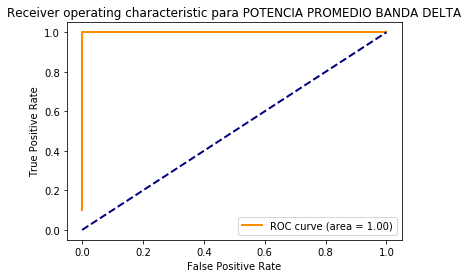

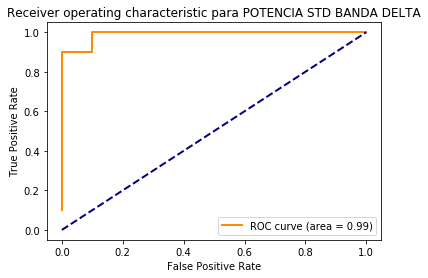

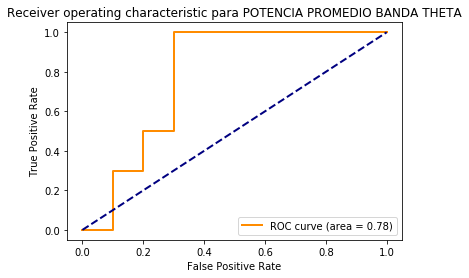

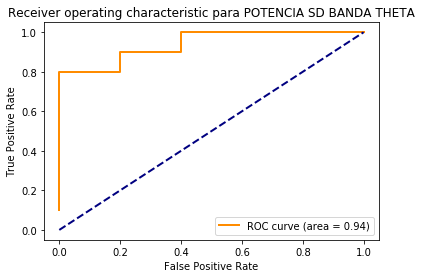

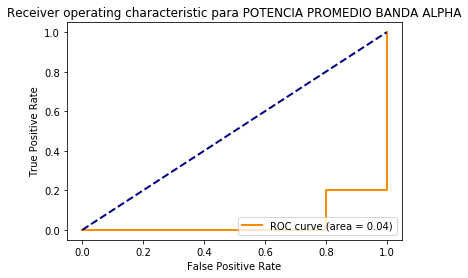

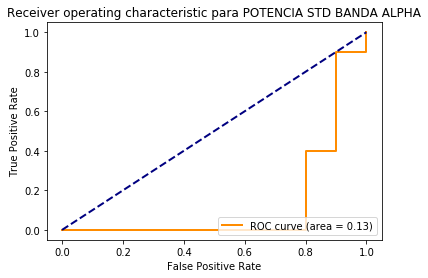

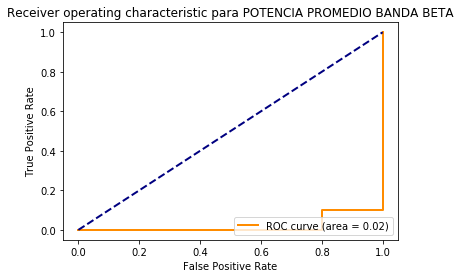

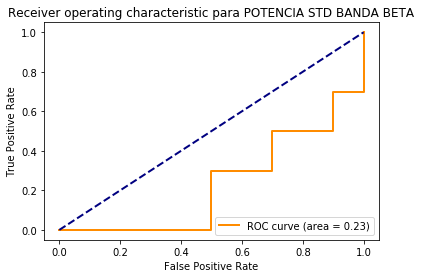

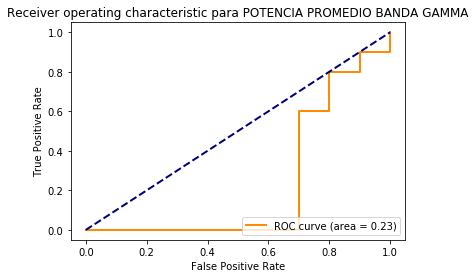

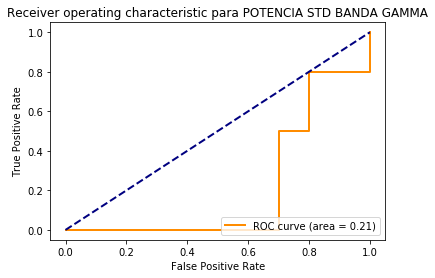

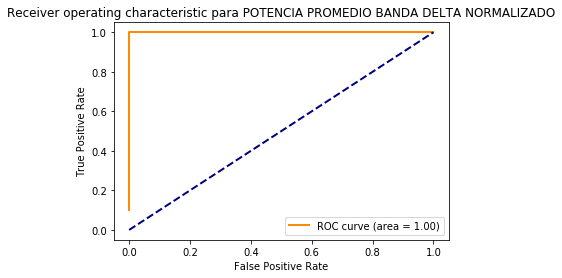

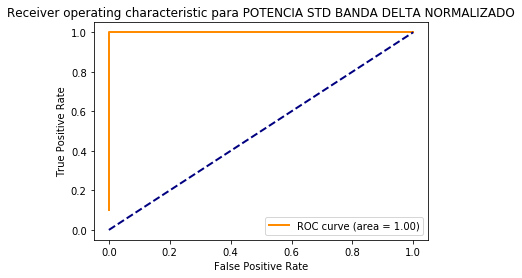

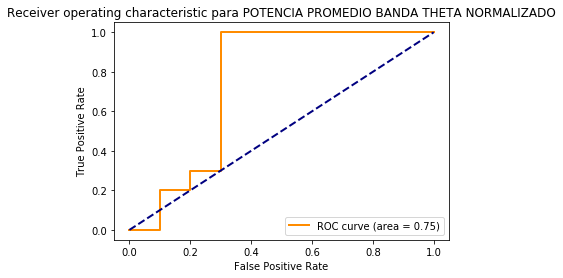

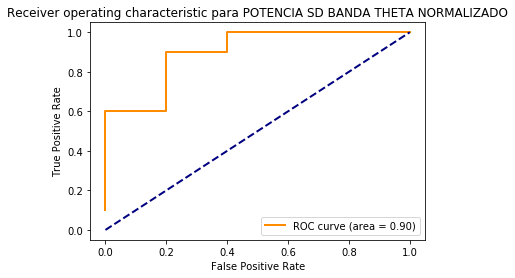

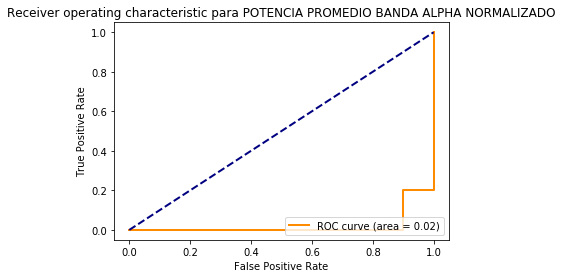

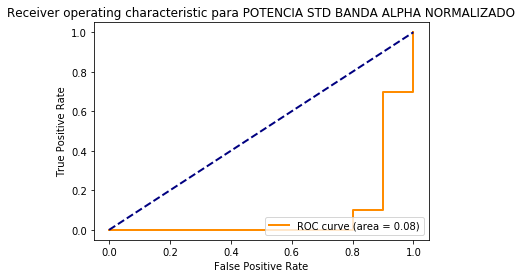

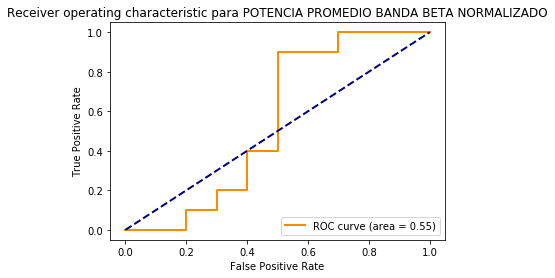

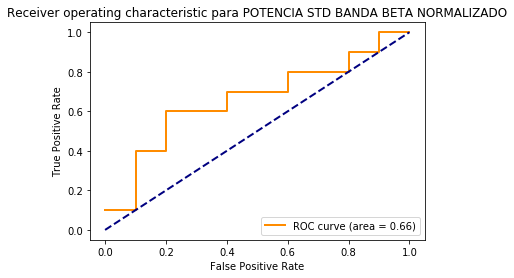

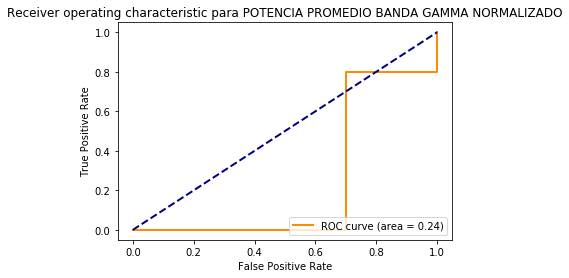

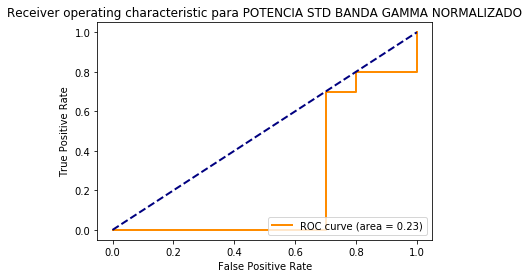

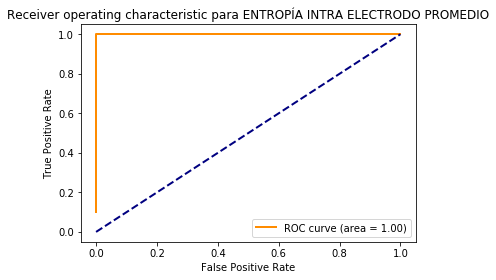

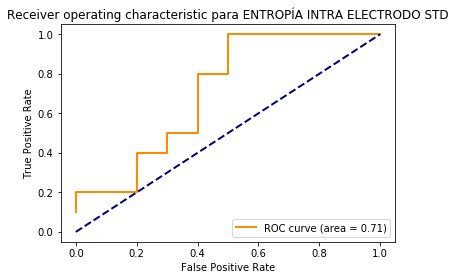

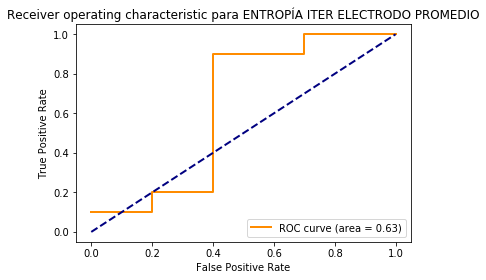

In [25]:
for k in range(23):

    fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,k],pos_label='P')
    lw = 2
    roc_auc = metrics.auc(fpr,tpr)
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic para '+field[k])
    plt.legend(loc="lower right")
    plt.show()

Como observamos, las bandas de menor frecuencia (deta y theta) presentan un elevado score para sus promedios lo que creemos que puede deberse a la reacción ante el estímulo eléctrico presentado por los pacientes normales que difiere notáblemente de los de mínima consciencia.

La media de la entropía intra electrodo logra una clasificación perfecta por lo que nuestra medida de información intra eletrodo aflora relevante a la hora de clasificar a los pacientes.

Contrariamente a lo que podíamos haber hipotetizado, el desvío standard de los feautres en el tiempo no logra mejorar la clasificación respecto al promedio. 

Notar que en los casos donde la cruva cae por debajo de la diagonal podemos invertir la etiqueta que denominamos positiva y obtendremos el resultado inverso.

## Ejercicio 2.1)b) Logistic regression

En este inciso utilizarmeos el clasificador Logistic Regression para cada uno de los feautures y lo compararemos con la capacidad de discriminación de dichos rasgos calculada antes. Debido a que contamos con pocos pacientes y el clasificador necesita entrenarse en un subcojunto de los mismos y testear su modelo en otro (pudiendo luego calcular la ROC curve ya que sí disponemos de las etiquetas), realizaremos una técnica de Cross Validation, en particular K fold. 
En esta partimos el conjunto de pacientes en k subconjuntos y entrenamos en todos menos ese y testeamos en este. Así k veces.

Con lo cual obtendremos k curvas roc y realizaremos un promedio de las mismas para comparar con lo obtenido en el inciso anterior.

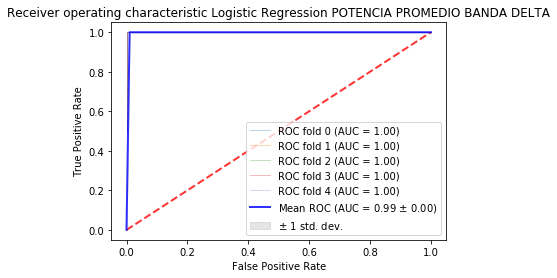

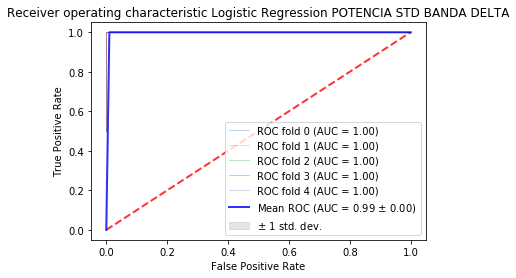

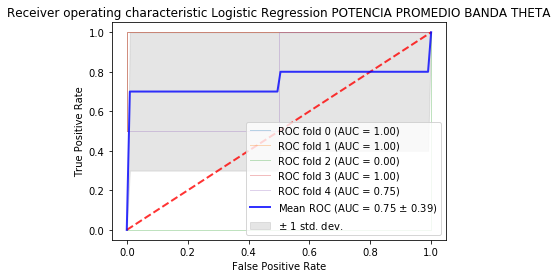

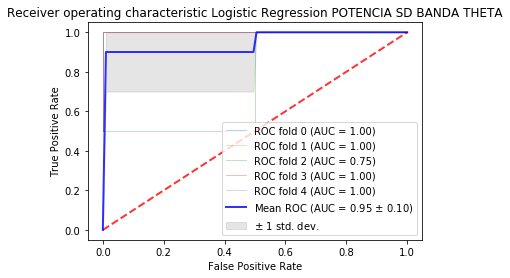

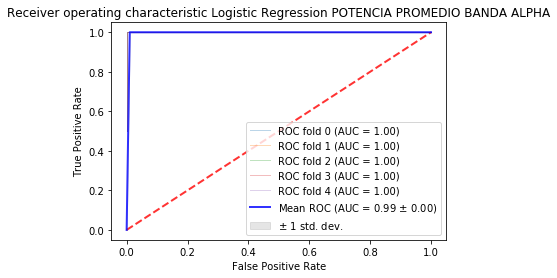

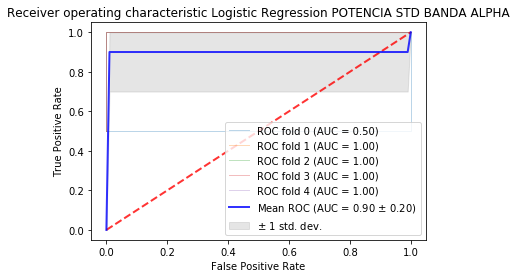

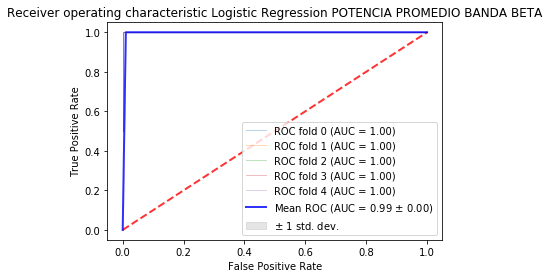

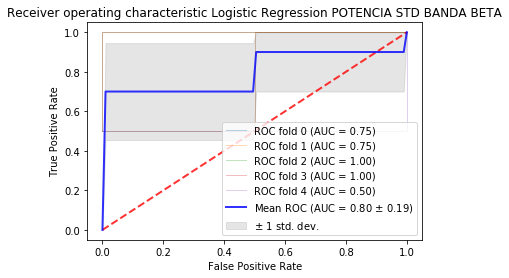

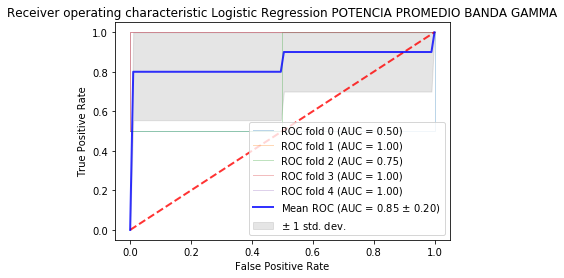

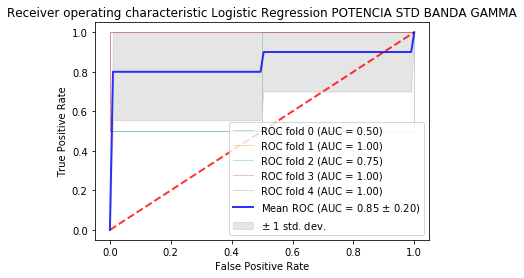

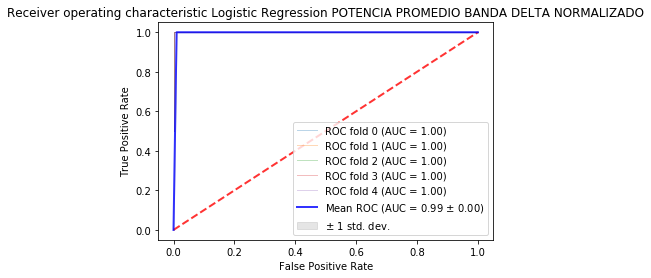

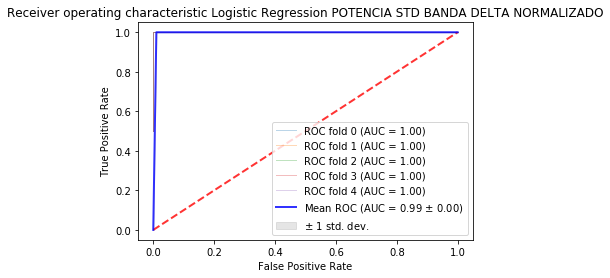

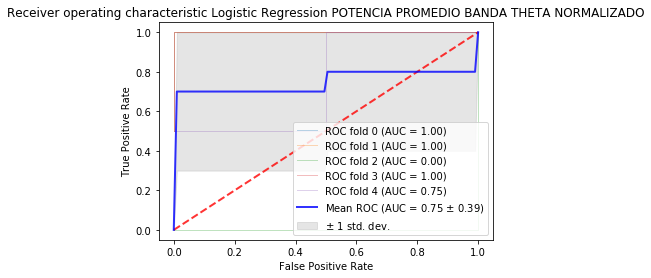

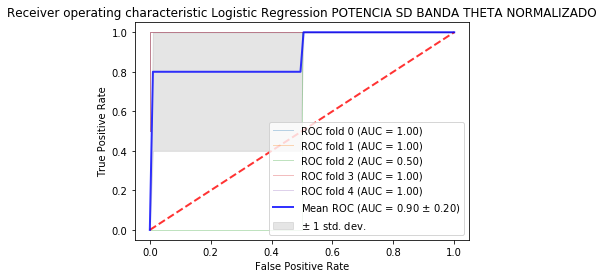

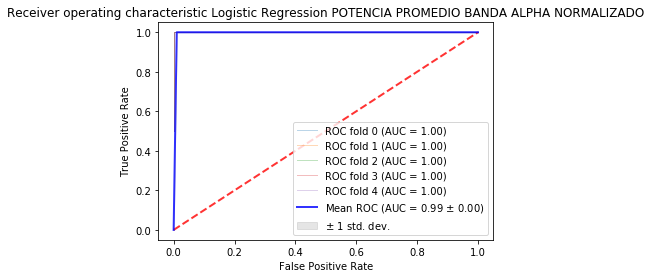

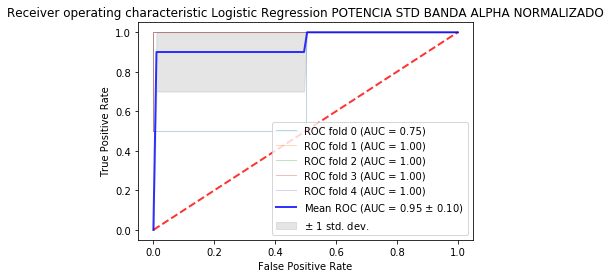

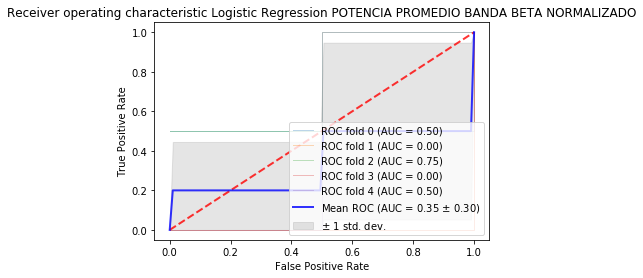

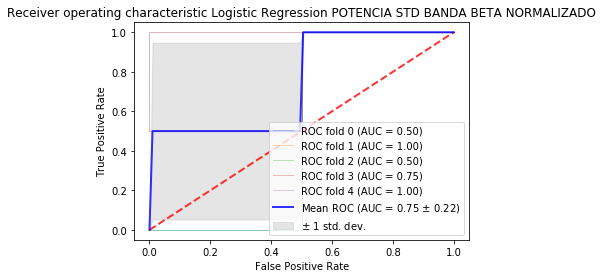

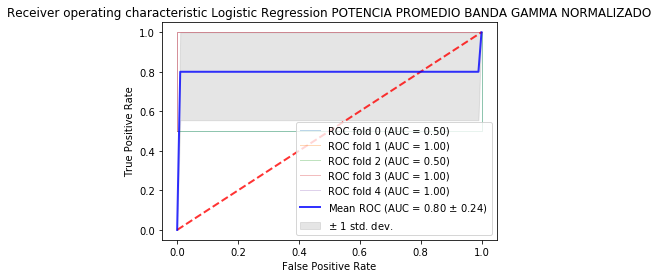

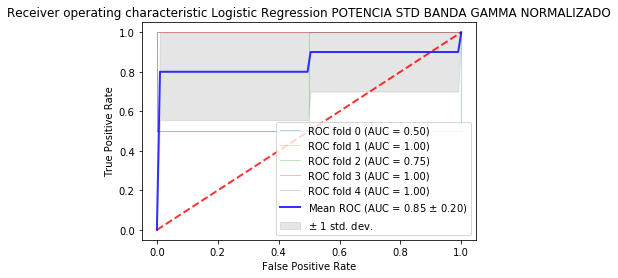

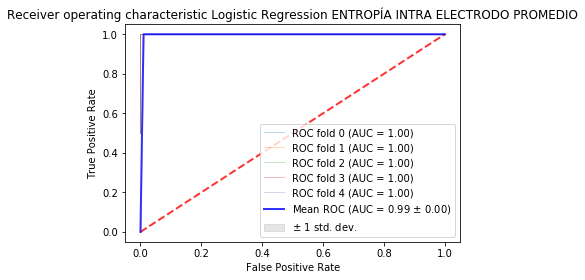

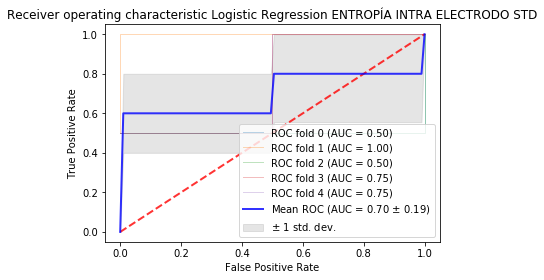

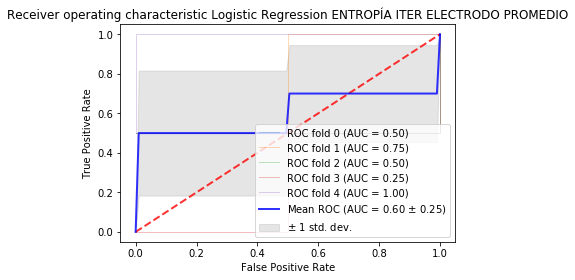

In [21]:
for k in range(23):

    classifier = LogisticRegression()

    cv = StratifiedKFold(n_splits=5)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    X = patient_features[:,k]*1e12
    y = patients_labels

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train].reshape(-1,1), y[train]).predict_proba(X[test].reshape(-1,1))
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = metrics.roc_curve(y[test], probas_[:, 1], pos_label='S')
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic Logistic Regression '+field[k])
    plt.legend(loc="lower right")
    plt.show()

Notamos que la seleccion de features es una pieza clave a la hora de entrenar un clasificador a partir de estos.

Creemos que es importante el analisis por separado de cada uno de estos ya que nos da una idea de cuales son los que ayudan a determinar una caracterizacion más representativa de las clases existentes para la clasificacion de las muestras.

Una segunda conclusion importante, viendo el grafico obtenido luego de realizar la tecnica de cross validation, es que
la performance del clasificador no solo esta ligada a la obtencion y seleccion de los mejores features sino tambien
a la cantidad y calidad de las muestras a utilizar en el entrenamiento. Así lo muestran las diferentes curvas ROC obtenidas arriba en el cual la performance de los diferentes Folds varia, no dependendiendo del feature el cual es fijo, sino de las muestras utilizadas en cada uno de estos (razon por la cual se utiliza luego la media para dar una idea global del clasificador).

Comparando cada resultado con su par en el inciso anterior, los resultados son iguales o mejores (esto es, el área bajo la curva es igual a mayor al reportado utilizando solo el feauture) lo que creemos que se debe a la capacidad del clasificador logistic regression de generalizar un poco mejor el modelo a partir de ajustarse a diferentes subconjutos de los datos y testearse en diversos subconjuntos. Si bien son pocas las muestras que tenemos, la técnica de cross validation le permite al clasificador contar con más información para no sobreajustar tanto el modelo a un conjunto de muestras en particular y exprimir aún más el feauture sobre el cual dirime la clasificación. 


## 2) Análisis multivariado

## 2)a)

En este apartado analizaremos otro clasificador, el Support Vector Machine teniendo en cuenta más de un feauture. Como la sección precedente, graficaremos la curva ROC y mediremos el área bajo la cruva con el fin de obtener una métrica del rendimiento de dicha clasificación.

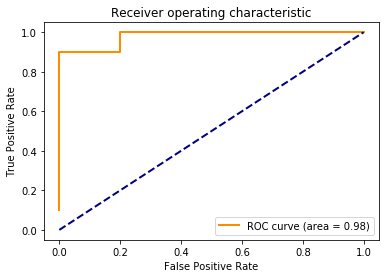

In [27]:
sup_vector_machine = svm.SVC(probability=True)
sup_vector_machine.fit(patient_features[:,:],patients_labels)

predicted_prob = sup_vector_machine.predict_proba(patient_features[:,:])

fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=predicted_prob[:,0], pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## 2)b)
Ahora lo que hacemos es aplicar técnicas de preprocesado para intentar que el svm clasifque mejor. 

Lo primero que realizamos es standarizarlo a varianza unitaria y sin media ya que este clasificador asume distribución normal de los datos y de no asemejarse a la misma podría decrementar su capacidad de discriminación.

Ahora bien, como no todos los feautures ostentan la misma importancia a la hora de explicar la pertenencia a una y otra clase y como la mayor cantidad de estos obliga a disponer de mayor cantidad de datos para hacer uso de los mismos sin caer en una redundancia que empeore al clasificador, tenemos que filtrar algunos ragos. 

Para ellos seleccionamos un porcentaje de feautures que se corresponden con los que mayor score aportan. 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


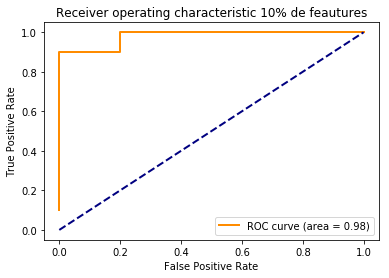

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


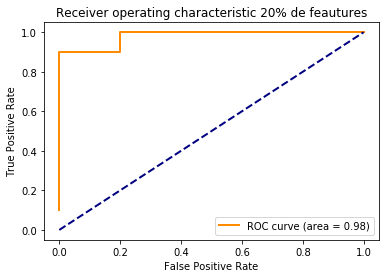

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [23] are constant.
  UserWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


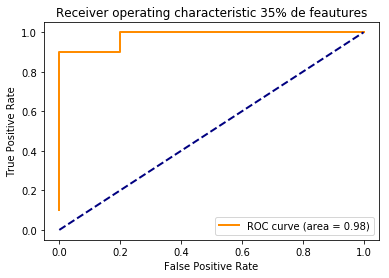

In [29]:
for porcentaje in [10,20,35]:
    scaler = StandardScaler()
    percentile_feature_selector = SelectPercentile(f_classif,percentile=porcentaje)
    clf = svm.SVC(kernel='linear', probability=True)
    pipeline = Pipeline([('scaler', scaler), ('feature_selector', percentile_feature_selector), ('clf', clf)])
    pipeline.fit(patient_features, patients_labels)
    pipeline.predict_proba(patient_features)

    fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=predicted_prob[:,0], pos_label='P')
    lw = 2
    roc_auc = metrics.auc(fpr,tpr)
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic '+str(porcentaje)+"% de feautures")
    plt.legend(loc="lower right")
    plt.show()



No notamos mucha diferencia respecto del primer inciso de este ejercicio, probablemente por la eficiencia del SVC y porque las features 
 tomadas son lo suficientemente representativas como para clasificar de manera aceptable y optima dentro de las limitaciones del problema.
 
 Aumentar el porcentaje de features y que nos de un mejor resultado en terminos de area bajo la curva significa estrictamente
 que nos hacia falta observar los features que dejamos excluidos: estos eran utiles para el clasificador
 para poder determinar a que clase pertenece cada paciente con una mayor precision. Una buena idea es buscar el mejor valor 
 de porcentaje, a utilizar para la extraccion de features a considerar en el entrenamiento, realizando una busqueda binaria de este valor, entre 1% y 100%, hasta encontrar el que nos brinde
 el mejor resultado en terminos de AUC y parar de buscarlo cuando no se aprecie (al aumentar este porcentaje) un cambio significativo en la AUC. 
 
 Estan esos dos bordes: considerar features de menos, lo cual no nos dara el mejor clasificador, y considerar features de mas, los cuales no aportan informacion caracteristica
 de cada clase utilizada para clasificar.